In [3]:
%matplotlib inline

import datetime
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

# How to enable Colab GPUs https://colab.research.google.com/notebooks/gpu.ipynb
# Select the Runtime > "Change runtime type" menu to enable a GPU accelerator,
# and then re-execute this cell.
if 'google.colab' in str(get_ipython()):
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))

import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Input, InputLayer, Dense, Dropout, Activation, Conv1D, \
                         BatchNormalization, GlobalAveragePooling1D, Flatten, \
                         Reshape, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reduces variance in results but won't eliminate it :-(
%env PYTHONHASHSEED=0
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

env: PYTHONHASHSEED=0


# LSTM Networks for Cambridge UK Weather Time Series

Building LSTM models for time series analysis of Cambridge UK temperature measurements taken at the [University computer lab weather station](https://www.cl.cam.ac.uk/research/dtg/weather/).

This notebook is being developed on [Google Colab](https://colab.research.google.com), primarily using [keras/tensorflow](https://www.tensorflow.org/guide/keras/sequential_model).  I'm primarily interested in short term temperature forecasts (less than 2 hours) but will include results up to 24 hours in the future.

See my previous work for further details:
 * [Cambridge UK temperature forecast python notebooks](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks)
 * [Cambridge UK temperature forecast R models](https://github.com/makeyourownmaker/CambridgeTemperatureModel)
 * [Bayesian optimisation of prophet temperature model](https://github.com/makeyourownmaker/BayesianProphet)
 * [Cambridge University Computer Laboratory weather station R shiny web app](https://github.com/makeyourownmaker/ComLabWeatherShiny)

In particular, see the [keras_mlp_fcn_resnet_time_series.ipynb notebook](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/keras_mlp_fcn_resnet_time_series.ipynb), which uses a streamlined version of data preparation from [Tensorflow time series forecasting tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series).  That notebook showed promising results for LSTM networks.

Most of the above repositories, notebooks, web apps etc were built on both less data and less thoroughly cleaned data.

## Import Data

The measurements are relatively noisy and there are usually several hundred missing values every year.
Observations have been extensively cleaned but may still have issues.  Interpolation and missing value imputation have been used to fill all missing values.  See the [cleaning section](https://github.com/makeyourownmaker/CambridgeTemperatureModel#Cleaning) in the [Cambridge Temperature Model repository](https://github.com/makeyourownmaker/CambridgeTemperatureModel) for details.  Observations start in August 2008 and end in April 2021 and occur every 30 mins.

Shape:
(223250, 7)

Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 223250 entries, 2008-08-01 00:30:00 to 2021-04-26 01:00:00
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ds                 223250 non-null  datetime64[ns]
 1   y                  223250 non-null  float64       
 2   humidity           223250 non-null  float64       
 3   dew.point          223250 non-null  float64       
 4   pressure           223250 non-null  float64       
 5   wind.speed.mean    223250 non-null  float64       
 6   wind.bearing.mean  223250 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 13.6 MB
None

Summary stats:


,y,humidity,dew.point,pressure,wind.speed.mean,wind.bearing.mean
count,223250.000000,223250.000000,223250.000000,223250.000000,223250.000000,223250.000000
mean,10.000512,78.689959,58.880634,1014.336135,4.432390,195.051399
std,6.496255,17.274417,51.630120,11.935364,4.013553,82.881764
min,-7.000000,20.000000,-100.000000,963.000000,0.000000,0.000000
25%,5.200000,68.000000,20.000000,1008.000000,1.200000,135.000000
50%,9.600000,83.000000,60.000000,1016.000000,3.500000,225.000000
75%,14.500000,92.000000,97.000000,1022.000000,6.600000,270.000000
max,36.100000,100.000000,209.000000,1051.000000,29.200000,360.000000



Raw data:


,ds,y,humidity,dew.point,pressure,wind.speed.mean,wind.bearing.mean
ds,,,,,,,
2008-08-01 00:30:00,2008-08-01 00:30:00,19.5,65.75000,119.150000,1014.416667,1.150000,225.0
2008-08-01 01:00:00,2008-08-01 01:00:00,19.1,49.75000,79.200000,1014.384615,1.461538,225.0
2008-08-01 01:30:00,2008-08-01 01:30:00,19.1,66.17875,106.600000,1014.500000,1.508333,225.0
2008-08-01 02:00:00,2008-08-01 02:00:00,19.1,58.50000,99.250000,1014.076923,1.430769,225.0
2008-08-01 02:30:00,2008-08-01 02:30:00,19.1,66.95000,121.883333,1014.416667,1.133333,225.0
...,...,...,...,...,...,...,...
2021-04-25 23:00:00,2021-04-25 23:00:00,3.6,61.00000,-32.000000,1028.000000,1.400000,45.0
2021-04-25 23:30:00,2021-04-25 23:30:00,3.6,64.00000,-26.000000,1028.000000,2.600000,45.0
2021-04-26 00:00:00,2021-04-26 00:00:00,3.6,58.00000,-39.000000,1028.000000,4.300000,45.0


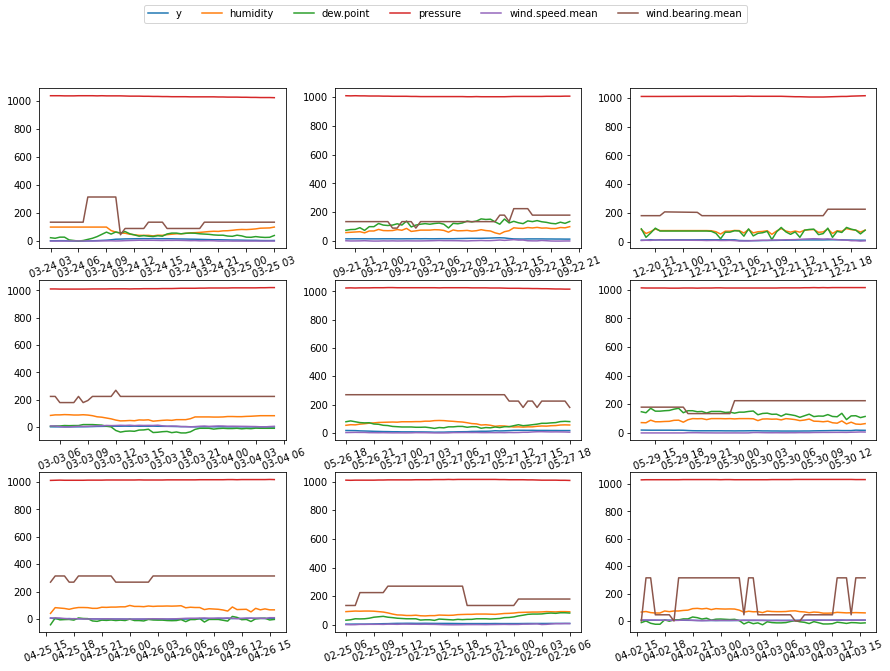

In [4]:
if 'google.colab' in str(get_ipython()):
    data_loc = "https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/data/CamMetCleanish2021.04.26.csv?raw=true"
else:
    data_loc = "../data/CamMetCleanish2021.04.26.csv"
df = pd.read_csv(data_loc, parse_dates = True)

df['ds'] = pd.to_datetime(df['ds'])
df.set_index(df['ds'], drop = False, inplace = True)
df = df[~df.index.duplicated(keep = 'first')]

df['y'] = df['y'] / 10
df['wind.speed.mean'] = df['wind.speed.mean'] / 10

df = df.loc[df['ds'] > '2008-08-01 00:00:00',]

print("Shape:")
print(df.shape)
print("\nInfo:")
print(df.info())
print("\nSummary stats:")
display(df.describe())
print("\nRaw data:")
display(df)
print("\n")


def plot_examples(data, x_var):
    """Plot 9 sets of observations in 3 * 3 matrix ..."""

    assert len(data) == 9

    cols = [col for col in data[0].columns if col != x_var]

    fig, axs = plt.subplots(3, 3, figsize = (15, 10))
    axs = axs.ravel()  # apl for the win :-)

    for i in range(9):
      for col in cols:
        axs[i].plot(data[i][x_var], data[i][col])
        axs[i].xaxis.set_tick_params(rotation = 20, labelsize = 10)
    
    fig.legend(cols, loc = 'upper center',  ncol = len(cols))
    
    return None


cols = ['ds', 'y', 'humidity', 'dew.point', 'pressure', 
        'wind.speed.mean', 'wind.bearing.mean']
ex_plots = 9
hour_window = 24
starts = df.sample(n = ex_plots).index
p_data = [df.loc[starts[i]:starts[i] + datetime.timedelta(hours = hour_window), cols] 
          for i in range(ex_plots)]
plot_examples(p_data, 'ds')



---

## Data Processing and Feature Engineering

The data must be reformatted before model building.

The following steps are carried out:

 * Wind direction and speed transformation
 * Time conversion
 * Train test data separation
 * Normalise data
 * Window data

### Wind direction and speed transformation

The `wind.bearing.mean` column gives wind direction in degrees but is  categorised at 45 degree increments, i.e. 0, 45, 90, 135, 180, 225, 270, 315. Wind direction shouldn't matter if the wind is not blowing.

The distribution of wind direction and speed looks like this:

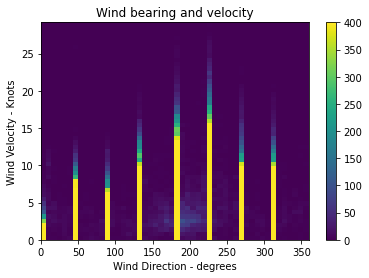

In [5]:
plt.hist2d(df['wind.bearing.mean'], df['wind.speed.mean'], bins = (50, 50), vmax = 400)
plt.colorbar()
plt.xlabel('Wind Direction - degrees')
plt.ylabel('Wind Velocity - Knots')
plt.title('Wind bearing and velocity');

Convert wind direction and speed to x and y vectors, so the model can more easily interpret them.

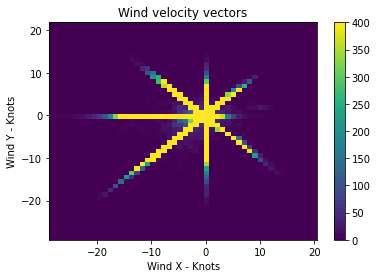

In [6]:
wv = df['wind.speed.mean']

# Convert to radians
wd_rad = df['wind.bearing.mean'] * np.pi / 180

# Calculate the wind x and y components
df['wind.x'] = wv * np.cos(wd_rad)
df['wind.y'] = wv * np.sin(wd_rad)

df_orig = df

plt.hist2d(df['wind.x'], df['wind.y'], bins = (50, 50), vmax = 400)
plt.colorbar()
plt.xlabel('Wind X - Knots')
plt.ylabel('Wind Y - Knots')
plt.title('Wind velocity vectors');


Better, but not ideal. Data augmentation with the [mixup method](https://arxiv.org/abs/1710.09412) is carried out below.

From the [mixup paper](https://arxiv.org/abs/1710.09412): "mixup trains a neural network on convex combinations of pairs of examples and their labels".

Further details on how I apply mixup to time series are included in the Window data section of my [keras_mlp_fcn_resnet_time_series.ipynb notebook](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/keras_mlp_fcn_resnet_time_series.ipynb).

Here is an illustration of the improvement in wind velocity sparsity with mixup augmentation.

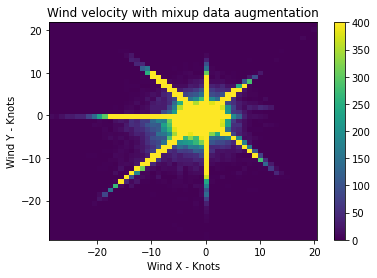

In [7]:
def mixup(data, alpha = 1.0, factor = 1):
    batch_size = len(data) - 1
    
    data['epoch'] = data.index.astype(np.int64) // 10**9
    
    # random sample lambda value from beta distribution
    l   = np.random.beta(alpha, alpha, batch_size * factor)
    X_l = l.reshape(batch_size * factor, 1)
    
    # Get a pair of inputs and outputs
    y1  = data['y'].shift(-1).dropna()
    y1_ = pd.concat([y1] * factor)
    
    y2  = data['y'][0:batch_size]
    y2_ = pd.concat([y2] * factor)

    X1  = data.drop('y', 1).shift(-1).dropna()
    X1_ = pd.concat([X1] * factor)
    
    X2  = data.drop('y', 1)
    X2  = X2[0:batch_size]
    X2_ = pd.concat([X2] * factor)

    # Perform mixup
    X = X1_ * X_l + X2_ * (1 - X_l)
    y = y1_ * l   + y2_ * (1 - l)    
    
    df = pd.DataFrame(y).join(X)    
    df = data.append(df).sort_values('epoch', ascending = True)
    df = df.drop('epoch', 1)
    data = data.drop('epoch', 1)
    
    df = df.drop_duplicates(keep = False)
    
    return df


df_mix = mixup(df.loc[:, ['y', 'wind.x', 'wind.y']], factor = 2)
plt.hist2d(df_mix['wind.x'], df_mix['wind.y'], bins = (50, 50), vmax = 400)
plt.colorbar()
plt.xlabel('Wind X - Knots')
plt.ylabel('Wind Y - Knots')
plt.title('Wind velocity with mixup data augmentation');

Mixup improves the categorical legacy of the wind velocity data. Unfortunately, if outliers are present their influence will likely be reinforced.

See my [keras_mlp_fcn_resnet_time_series.ipynb notebook](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/keras_mlp_fcn_resnet_time_series.ipynb) for an illustration of the profoundly beneficial improvement mixup provides with this dataset.

---

### Time conversion

Convert `ds` timestamps to "time of day" and "time of year" variables using `sin` and `cos` functions.

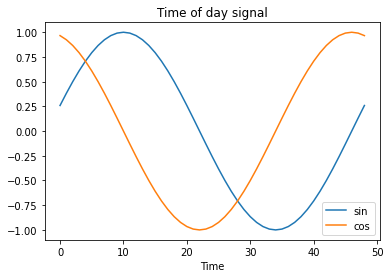

In [8]:
# Convert to secs
date_time   = pd.to_datetime(df['ds'], format = '%Y.%m.%d %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)

day  = 24 * 60 * 60
year = 365.2425 * day

df['day.sin']  = np.sin(timestamp_s * (2 * np.pi / day))
df['day.cos']  = np.cos(timestamp_s * (2 * np.pi / day))
df['year.sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['year.cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(df['day.sin'])[49:98])
plt.plot(np.array(df['day.cos'])[49:98])
plt.xlabel('Time')
plt.legend(['sin', 'cos'], loc = 'lower right')
plt.title('Time of day signal');

The yearly time components may benefit from a single phase shift so they align with the seasonal temperature peak around the end of July and temperature trough around the end of January.  Similarly, the daily components may benefit from small daily phase shifts.

---

### Time Components with Tuned Frequencies and Phase Shifts

It may be possible to improve forecasts by tuning frequencies and phase shifts in the sin/cos yearly/daily time components I've used in this and previous notebooks.  Alternatively, the Fourier series could be improved.

...

Methods:
  * savgol_filter
  * lowess
  * Phase-shifted time components
  * Fourier series
    * Code adapted from [here](https://stackoverflow.com/a/4266499/100129) and [here](https://stackoverflow.com/a/54639960/100129)

...

Yearly time components first:
  * ...

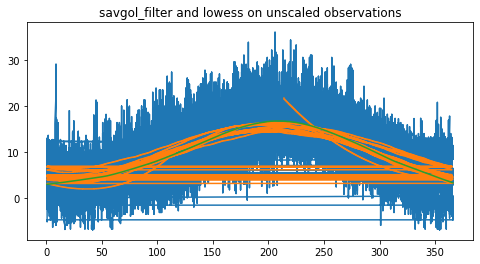

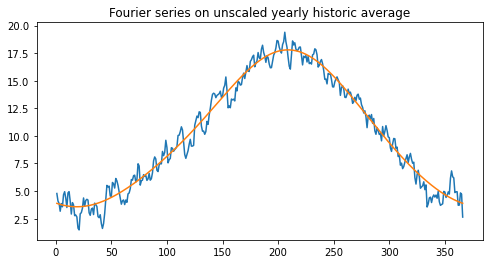

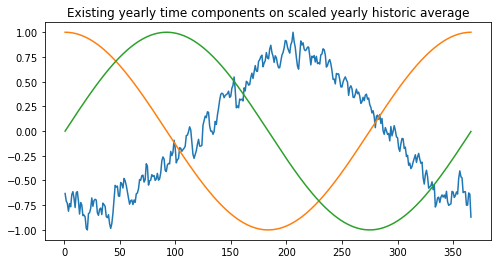

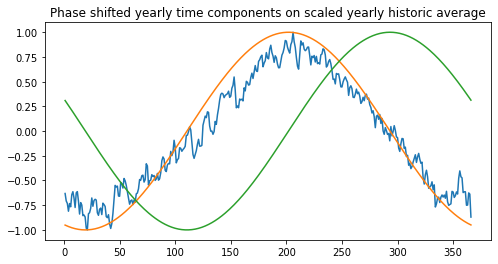

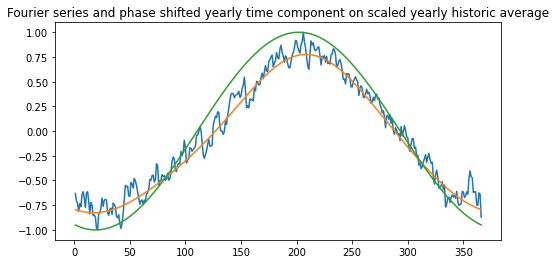

In [15]:
df['doy'] = df.index.dayofyear
df['hms'] = df.index.time


from scipy.signal import savgol_filter
y_savgol = savgol_filter(df.y, 17567, 3)  
# 17567 number of annual observations - 1
# 17567 = 48 * 366 - 1


import statsmodels.api as sm
y_lowess = sm.nonparametric.lowess(df.y, df.doy, frac = 0.3)

plt.figure(figsize = (8, 4))
plt.plot(df.doy, df.y)
plt.plot(df.doy, y_savgol)
plt.plot(y_lowess[:, 0], y_lowess[:, 1])
plt.title("savgol_filter and lowess on unscaled observations")
plt.show()


# ha - historic average
ha = pd.DataFrame(df.groupby(['doy']).y.mean())
ha.reset_index(inplace = True) 


def cn(n, y, period = 365.2425):
   c = y * np.exp(-1j * 2 * n * np.pi * days / period)
   return c.sum() / c.size

def f(x, y, Nh, period = 365.2425):
   f = np.array([2 * cn(i, y) * np.exp(1j * 2 * i * np.pi * x / period) for i in range(0, Nh + 1)])
   return f.sum()


days = np.array([i for i in range(0, 366)])
y_fourier_u = np.array([f(t, ha.y, 3).real for t in days])  
# u - unscaled
# TODO min max scale y3

plt.figure(figsize = (8, 4))
plt.plot(ha.doy, ha.y)
plt.plot(ha.doy, y_fourier_u - 10)
plt.title("Fourier series on unscaled yearly historic average")
plt.show()


def rmse(x, xp):
  return ((x - xp) ** 2).mean() ** .5

#print(rmse(ha.y, y_fourier_u - 10))


ha_y_min = min(ha.y)
ha.y = ha.y - ha_y_min

ha_y_max = max(ha.y)
ha.y = ha.y / ha_y_max
ha.y = (ha.y - 0.5) * 2

ha['year.cos.1'] = np.cos(days * (2 * np.pi / 365.2425))
ha['year.sin.1'] = np.sin(days * (2 * np.pi / 365.2425))

plt.figure(figsize = (8, 4))
plt.plot(ha.doy, ha.y)
plt.plot(ha.doy, ha['year.cos.1'])
plt.plot(ha.doy, ha['year.sin.1'])
plt.title("Existing yearly time components on scaled yearly historic average")
plt.show()

j = 0
for i in np.linspace(0, 1, 20) * 2 * np.pi:
  ha['year.cos.1.ps'] = np.cos(days * (2 * np.pi / 365.2425) + i)  # ps - phase shift
  # print(j, j * 2 * np.pi / 20, rmse(ha.y, ha['year.cos.1']))
  j += 1

ha['year.sin.1.ps'] = np.sin(days * (2 * np.pi / 365.2425) + 2 * 9 * np.pi / 20)
ha['year.cos.1.ps'] = np.cos(days * (2 * np.pi / 365.2425) + 2 * 9 * np.pi / 20)

#print(rmse(ha.y, ha['year.cos.1']))
#print(rmse(ha.y, -ha['year.cos.1']))

plt.figure(figsize = (8, 4))
plt.plot(ha.doy, ha.y)
plt.plot(ha.doy, ha['year.cos.1.ps'])
plt.plot(ha.doy, ha['year.sin.1.ps'])
plt.title("Phase shifted yearly time components on scaled yearly historic average")
plt.show()


y_fourier_s = np.array([f(t, ha.y, 3).real for t in days])  # s - scaled
#print(rmse(ha.y, y_fourier_s))

plt.figure(figsize = (8, 4))
plt.plot(ha.doy, ha.y)
plt.plot(ha.doy, y_fourier_s)
plt.plot(ha.doy, ha['year.cos.1.ps'])
plt.title("Fourier series and phase shifted yearly time component on scaled yearly historic average")
plt.show()

...

Daily time components second:
 * ...

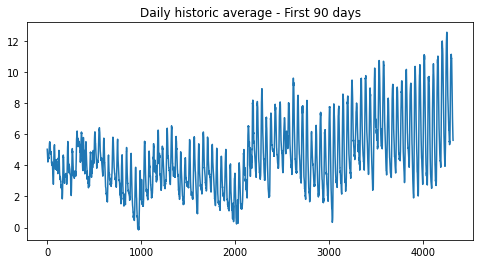

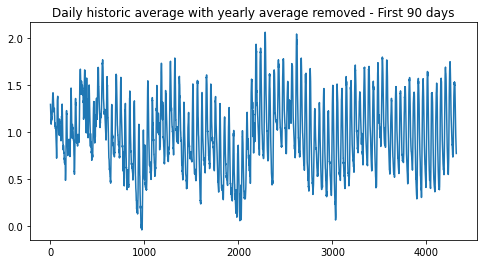

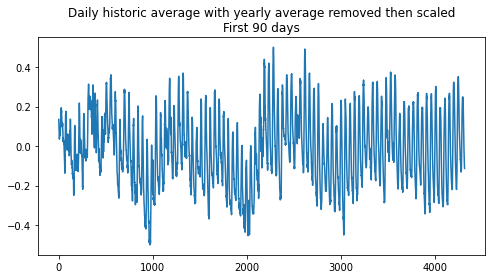

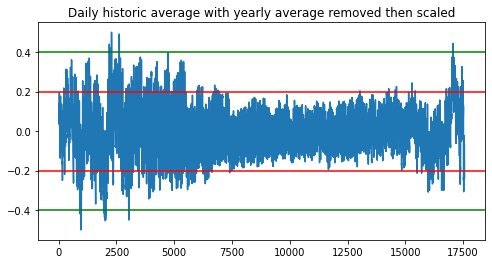

NameError: ignored

In [32]:
# df['hms'] = df.index.time

# ha - historic average
ha = pd.DataFrame(df.groupby(['doy', 'hms']).y.mean())
ha.reset_index(inplace = True) 

ticks = range(4320)
plt.figure(figsize = (8, 4))
plt.plot(ticks, ha.y[:4320])
plt.title("Daily historic average - First 90 days")
plt.show()


# TODO Subtract yearly historic averages
y_fourier_u_long = np.repeat(y_fourier_u, 48)
#display(y_fourier_u_long - 10)

ha['y_daily'] = ha['y'] / (y_fourier_u_long - 10)

ha['y_daily_s'] = ha['y_daily'] - min(ha['y_daily'])
ha['y_daily_s'] = ha['y_daily_s'] / max(ha['y_daily_s'])

#display(ha)

plt.figure(figsize = (8, 4))
plt.plot(ticks, ha.y_daily[:4320])
plt.title("Daily historic average with yearly average removed - First 90 days")
plt.show()

plt.figure(figsize = (8, 4))
plt.plot(ticks, ha.y_daily_s[:4320] - 0.5)
plt.title("Daily historic average with yearly average removed then scaled\nFirst 90 days")
plt.show()

ticks = range(17568)
plt.figure(figsize = (8, 4))
plt.plot(ticks, ha.y_daily_s - 0.5)
plt.axhline(y =  0.4, color='g', linestyle='-')
plt.axhline(y = -0.4, color='g', linestyle='-')
plt.axhline(y =  0.2, color='r', linestyle='-')
plt.axhline(y = -0.2, color='r', linestyle='-')
plt.title("Daily historic average with yearly average removed then scaled")
plt.show()

stop()


time = np.array([i for i in range(0, 17568)])

def cn(n, y, period = 48):
   c = y * np.exp(-1j * 2 * n * np.pi * time / period)
   return c.sum() / c.size

def f(x, y, Nh, period = 48):
   f = np.array([2 * cn(i, y) * np.exp(1j * 2 * i * np.pi * x / period) for i in range(0, Nh + 1)])
   return f.sum()


y4 = np.array([f(t, ha.y, 3).real for t in time])
print(rmse(ha.y, y4))

plt.figure(figsize = (8, 4))
plt.plot(ha.doy, ha.y)
plt.plot(ha.doy, y4)
plt.title("Fourier series on unscaled daily historic average")
plt.show()

...

---

### Split data¶

I use data from 2018 for validation, 2019 for testing and the remaining data for training. These are entirely arbitrary choices. This results in an approximate 84%, 8%, 8% split for the training, validation, and test sets respectively.

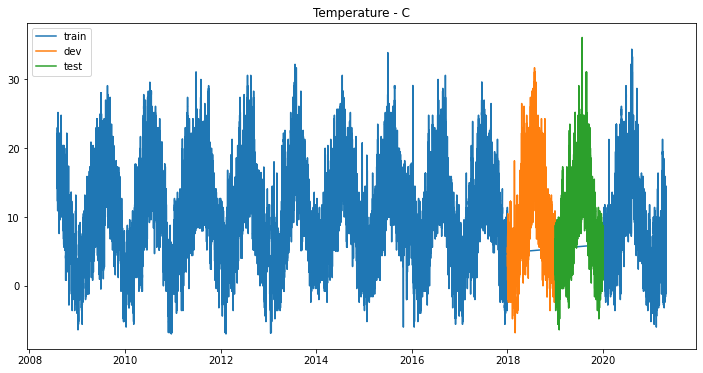

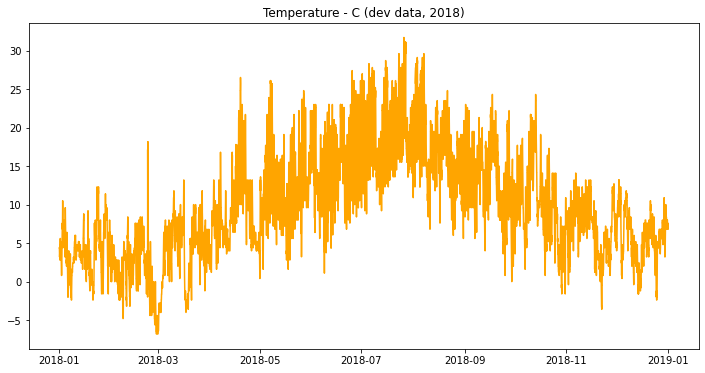

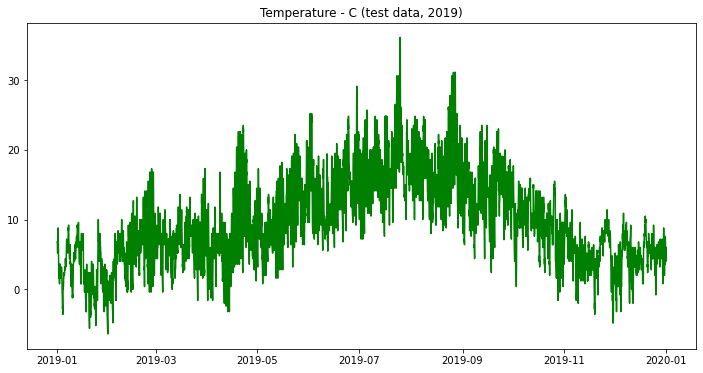

df.drop shape:  (223250, 10)
train shape:    (188210, 10)
valid shape:    (17520, 10)
test shape:     (17520, 10)


In [8]:
keep_cols = ['y', 'humidity', 'dew.point', 'pressure', 'wind.x', 'wind.y',
             'day.sin', 'day.cos', 'year.sin', 'year.cos']

df['year'] = df['ds'].dt.year
train_df = df.loc[(df['year'] != 2018) & (df['year'] != 2019)]
valid_df = df.loc[df['year'] == 2018]
test_df  = df.loc[df['year'] == 2019]


plt.figure(figsize = (12, 6))
plt.plot(train_df.ds, train_df.y)
plt.plot(valid_df.ds, valid_df.y)
plt.plot(test_df.ds,  test_df.y)
plt.title('Temperature - C')
plt.legend(['train', 'dev', 'test'])
plt.show()

plt.figure(figsize = (12, 6))
plt.plot(valid_df.ds, valid_df.y, color='orange')
plt.title('Temperature - C (dev data, 2018)')
plt.show()

plt.figure(figsize = (12, 6))
plt.plot(test_df.ds, test_df.y, color='green')
plt.title('Temperature - C (test data, 2019)')
plt.show()


del_cols = ['ds', 'year', 'wind.speed.mean', 'wind.bearing.mean']
train_df = train_df.drop(del_cols, axis = 1)
valid_df = valid_df.drop(del_cols, axis = 1)
test_df  = test_df.drop(del_cols,  axis = 1)
df = df.drop(del_cols, axis = 1)

print("df.drop shape: ", df.shape)
print("train shape:   ", train_df.shape)
print("valid shape:   ", valid_df.shape)
print("test shape:    ", test_df.shape)


---

### Normalise data

Features should be scaled before neural network training. Arguably, scaling should be done using moving averages to avoid accessing future values.
Instead, simple [standard score](https://en.wikipedia.org/wiki/Standard_score) normalisation will be used.

Plot [violin plot](https://en.wikipedia.org/wiki/Violin_plot) to see distribution of features.

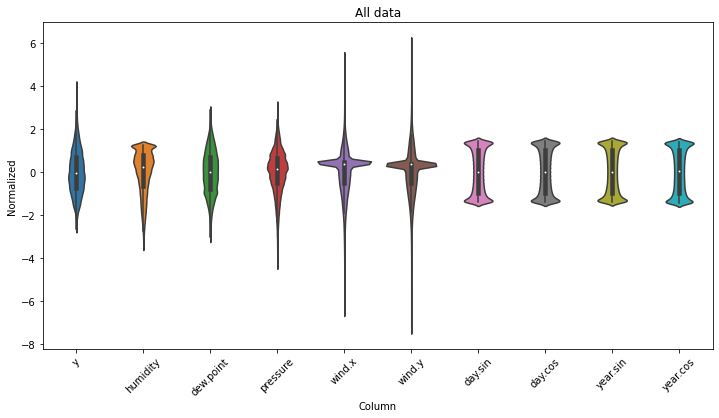

In [9]:
train_mean = train_df.mean()
train_std  = train_df.std()

train_df = (train_df - train_mean) / train_std
valid_df = (valid_df - train_mean) / train_std
test_df  = (test_df  - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name = 'Column', value_name = 'Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x = 'Column', y = 'Normalized', data = df_std)
ax.set_xticklabels(df.keys(), rotation = 45)
ax.set_title('All data');

There may still be some outliers present but there are no glaring problems.

---

### Window data

Models are trained using sliding windows of samples from the data.

Window parameters to consider for the 
[tf.keras.preprocessing.timeseries_dataset_from_array](https://keras.io/api/preprocessing/timeseries/#timeseries-data-preprocessing) 
function:
 * sequence_length:
   * Length of the output sequences (in number of timesteps), or number of **lag** observations to use
 * sequence_stride:
   * Period between successive output sequences. For stride s, output samples start at index data[i], data[i + s], data[i + 2 * s] etc
s can include an **offset** and/or 1 or more **steps ahead** to forecast
 * batch_size:
   * Number of samples in each batch
 * shuffle:
   * Shuffle output samples, or use chronological order

Initial values used:
 * sequence_length (aka lags): 24 (corresponds to 12 hours)
 * steps ahead (what to forecast): 
   *  1 - 30 mins
   *  4 - 30 mins, 60 mins, 90 mins and 120 mins
   * 48 - 30 mins, 60 mins ... 1,410 mins and 1,440 mins
 * offset (space between lags and steps ahead): 0
 * batch_size: 32
 * shuffle: True for training data

The `make_dataset` function below generates [tensorflow datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for:
 * Lags, steps-ahead, offset, batch size and shuffle
 * Optionally multiple y columns (Not extensively tested)
Stride is used to specify offset + steps-ahead. Offset will be 0 throughout this notebook.

**TODO** Insert figure illustrating lags, offsets and steps-ahead.

`shuffle = True` is used with train data. `shuffle = False` is used with validation and test data so the residuals can be checked for heteroscadicity.

Throughout this notebook I use a shorthand notation to describe lags and strides. For example:
 * 24l_1s_2m is 24 lags, 1 step ahead, 2 times mixup
 * 24l_4s_2m is 24 lags, 4 steps ahead, 2 times mixup

#### Mixup data augmentation

Data augmentation with 
[mixup: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412)
by Zhang _et al_ is used to help counter the categorical legacy from the wind bearing variable. Simple 'input mixup' is used as opposed to the batch-based mixup Zhang _et al_ focus on. Input mixup has the advantage that it can be used with non-neural network methods. With current settings these datasets are approximately 3 times larger but this can be varied. Three times more training data is manageable on Colab in terms of both training time and memory usage. Test and validation data is left unmodified.

I apply mixup between consecutive observations in the time series instead of the usual random observations. This is a fairly conservative starting point. I'd be surprised if applying mixup between consecutive days of measurements didn't give better results. Applying mixup between inputs with equal temperature values will not improve performance and will increase run time.

**TODO** Insert couple of examples of mixup - use `plot_examples()`

I don't show it in this notebook, but adding this data augmentation makes a big difference to loss values for all three model architectures. For example, here are results for a MLP with 24 largs, 1 step ahead, 20 epochs on both less data and less thoroughly cleaned data.

|Augmentation    |	Train rmse |	Train mae |	Valid rmse |	Valid mae |
|----------------|-------------|------------|------------|------------|
|No augmentation |	0.0058     |	0.053     |	0.0054     |	0.052     |
|Input mixup     |	0.0016     |	0.025     |	0.0015     |	0.025     |

See this [commit](https://github.com/makeyourownmaker/CambridgeTemperatureModel/blob/93c754d4b1b02e1bd8f827a6f6edc145824f6d23/notebooks/keras_mlp_fcn_resnet_time_series.ipynb) 
for results from other architectures without input mixup.

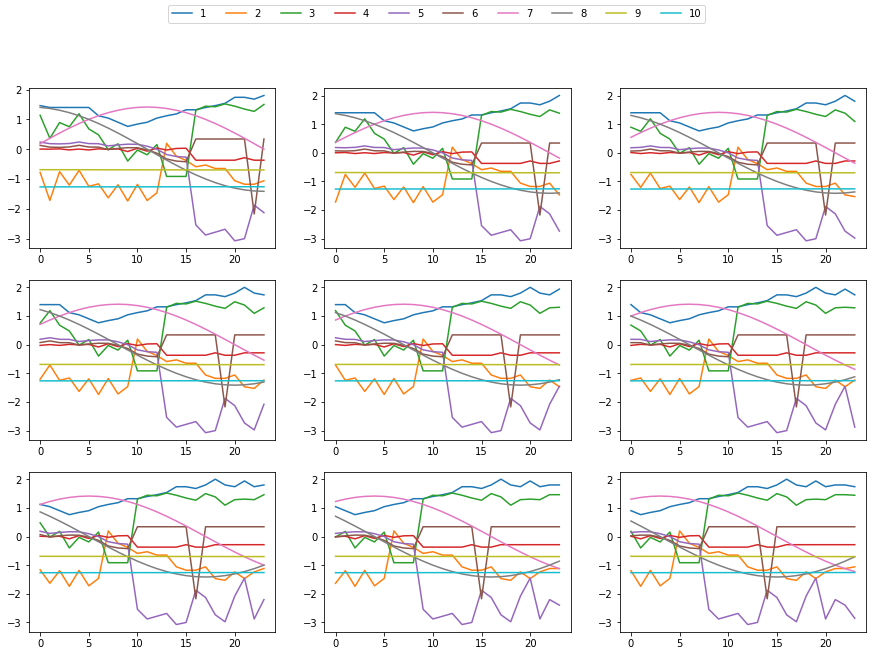

In [10]:
def make_dataset(data, y_cols, params):  
    assert params['stride'] >= params['steps_ahead']

    total_window_size = params['lags'] + params['stride']

    data = data.drop('epoch', axis = 1, errors = 'ignore')

    if params['mix'] != 0:
      data_mix = mixup(data, factor = params['mix'])
    else:
      data_mix = data

    data_mix = data_mix.drop('epoch', axis = 1, errors = 'ignore')
    data_np = np.array(data_mix, dtype = np.float32)
        
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
               data    = data_np,
               targets = None,
               sequence_length = total_window_size,
               sequence_stride = 1,
               shuffle    = params['shuffle'],
               batch_size = params['bs'])
      
    col_indices = {name: i for i, name in enumerate(data.columns)}
    X_slice = slice(0, params['lags'])
    y_start = total_window_size - params['steps_ahead']
    y_slice = slice(y_start, None)


    def split_window(features):
      X = features[:, X_slice, :]
      y = features[:, y_slice, :]

      # X = tf.stack(
      #        [X[:, :, col_indices[name]] for name in data.columns],
      #        axis = -1)    
      y = tf.stack([y[:, :, col_indices[name]] for name in y_cols], axis = -1)

      # Slicing doesn't preserve static shape info, so set the shapes manually.
      # This way the `tf.data.Datasets` are easier to inspect.
      X.set_shape([None, params['lags'],        None])
      y.set_shape([None, params['steps_ahead'], None])

      return X, y


    ds = ds.map(split_window)

    return ds   


def make_datasets(train, valid, test, params, y_cols = 'y'):
    ds_train = make_dataset(train, y_cols, params)

    params['shuffle'] = False
    ds_valid = make_dataset(valid, y_cols, params)

    params['mix'] = 0
    ds_test  = make_dataset(test,  y_cols, params)
    
    return ds_train, ds_valid, ds_test


def dataset_sanity_checks(data, name):    
    print(name, "batches: ", data.cardinality().numpy())
    for batch in data.take(1):
        print("\tX (batch_size, time, features): ", batch[0].shape)
        print("\ty (batch_size, time, features): ", batch[1].shape)
        print("\tX[0][0]: ", batch[0][0])
        print("\ty[0][0]: ", batch[1][0])
    

# Single step-ahead
ds = {}

params = {'lags':        24, 
          'steps_ahead':  1,
          'stride':       1, 
          'bs':          32,
          'shuffle':   True,
          'mix':          0}

#params['bs'] = 256
ds['train_24l_1s_t2v'], ds['valid_24l_1s_t2v'], ds['test_24l_1s_t2v'] = \
  make_datasets(train_df.loc[:, ['y']],
                valid_df.loc[:, ['y']],
                test_df.loc[:,  ['y']], 
                params)

#params['bs'] = 32
ds['train_24l_1s'], ds['valid_24l_1s'], ds['test_24l_1s'] = \
  make_datasets(train_df, valid_df, test_df, params)
# dataset_sanity_checks(ds['train_24l_1s'], '24l 1s train')

params['mix'] = 2
ds['train_24l_1s_2m'], ds['valid_24l_1s_2m'], ds['test_24l_1s_2m'] = \
  make_datasets(train_df, valid_df, test_df, params)


# 4 steps-ahead
params['mix'] = 0
params['steps_ahead'] = 4
params['stride']      = 4
ds['train_24l_4s'], ds['valid_24l_4s'], ds['test_24l_4s'] = \
  make_datasets(train_df, valid_df, test_df, params)

params['mix'] = 2
ds['train_24l_4s_2m'], ds['valid_24l_4s_2m'], ds['test_24l_4s_2m'] = \
  make_datasets(train_df, valid_df, test_df, params)

# display(train_df.head(params['lags'] + params['steps_ahead']))
# dataset_sanity_checks(ds['train_24l_4s'], '24l 4s train');


# Plot 9 examples from ds['train_24l_1s']
def plot_dataset_examples(dataset):
    fig, axs = plt.subplots(3, 3, figsize = (15, 10))
    axs = axs.ravel() 

    for batch in dataset.take(1):
        for i in range(9):
          x = batch[0][i].numpy()
          axs[i].plot(x)

    fig.legend(range(1, 11), loc = 'upper center',  ncol = 10);


plot_dataset_examples(ds['train_24l_1s'])


---

## LSTM Model Building

Long Short Term Memory networks, or LSTMs, were originally proposed in [LONG SHORT TERM MEMORY](https://www.bioinf.jku.at/publications/older/2604.pdf). They are recurrent neural networks which have feedback connections.

LSTMs can take entire sequences of data as input and keep track of arbitrary long-term dependencies. A LSTM unit is composed of a cell and three gates. The cell remembers values over arbitrary time intervals and the input, output and forget gates regulate the flow of information into and out of the cell.

**TODO** Include basic LSTM diagram

Forecast horizons:
  * next 30 mins - 1 step ahead
  * next 2 hours - 4 steps ahead
  * next 24 hours - 48 steps ahead
  * horizon is abbreviated to `h` in the interrim results tables **TODO** Check me

Metrics:
 * rmse - root mean squared error
 * mae - median absolute error
 * mape - mean absolute percentage error

...

LSTM enhancements:
 * vanilla
 * input mixup
 * time2vec
 * Fourier terms?
 * wind - drop or not?
 * `cos` time components - drop or not?
 * batch mixup
 * test time augmentation
 * ...

...

Parameters to consider optimising:
 * Learning rate - use LRFinder :-)
 * Optimiser - stick with Adam
 * Shuffle - true for training
 * Number of feature maps
   * 8, 16, 32
 * Lags
   * {1-24, 1-48} and {48, 96, 144, 192, 240, 288, 336}
 * mixup
   * factor - 1, 2, 3, 4, 5
   * alpha - 1, 2, 3, 4
 * dropout?
 * epochs
 * ...

...

LSTM architectures to consider:
 * Stacked LSTM
 * Bidirectional LSTM
 * CNN LSTM
 * ConvLSTM

...


---


### Learning rate finder
Leslie Smith was one of the first people to work on finding optimal learning rates for deep learning networks in [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186). Jeremy Howard from [fast.ai](https://www.fast.ai/) popularised the learning rate finder used here.

Before building any models, I use a modified version of [Pavel Surmenok's Keras learning rate finder](https://github.com/surmenok/keras_lr_finder) to get reasonably close to the optimal learning rate. It's a single small class which I add support for tensorflow datasets to, customise the graphics and add a simple summary function to.

In [34]:
from keras.callbacks import LambdaCallback
import keras.backend as K
import math


class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """

    def __init__(self, model):
        self.model  = model
        self.losses = []
        self.lrs    = []
        self.best_lr   = 0.001
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find_ds(self, train_ds, start_lr, end_lr, batch_size=64, epochs=1, **kw_fit):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        # N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]
        N = train_ds.cardinality().numpy()

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        #print(self.lr_mult)
        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(train_ds,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[callback],
                       **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, axs, sma, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        losses = self.losses[n_skip_beginning:-n_skip_end]
        best_lr = self.get_best_lr(sma=sma, n_skip_beginning=10, n_skip_end=5)

        axs[0].set_ylabel("loss")
        axs[0].set_xlabel("learning rate (log scale)")
        axs[0].plot(lrs, losses)
        axs[0].vlines(best_lr, np.min(losses), np.max(losses), linestyles='dashed')
        axs[0].set_xscale(x_scale)

    def plot_loss_change(self, axs, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=None):
        """
        Plots rate of change of the loss function.
        Parameters:
            axs - subplot axes
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        best_lr = self.get_best_lr(sma=sma, n_skip_beginning=n_skip_beginning, n_skip_end=n_skip_end)
        y_min, y_max = np.min(derivatives), np.max(derivatives)
        x_min, x_max = np.min(lrs), np.max(lrs)

        axs[1].set_ylabel("rate of loss change")
        axs[1].set_xlabel("learning rate (log scale)")
        axs[1].plot(lrs, derivatives)
        axs[1].vlines(best_lr, y_min, y_max, linestyles='dashed')
        axs[1].hlines(0, x_min, x_max, linestyles='dashed')
        axs[1].set_xscale('log')
        if y_lim == None:
            axs[1].set_ylim([y_min, y_max])
        else:
            axs[1].set_ylim(y_lim)

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmin(derivatives[n_skip_beginning:-n_skip_end])
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

    def summarise_lr(self, train_ds, start_lr, end_lr, batch_size=64, epochs=1, sma=1, n_skip_beginning=200, **kw_fit):
        self.find_ds(train_ds, start_lr, end_lr, batch_size, epochs)

        fig, axs = plt.subplots(1, 2, figsize = (9, 6), tight_layout = True)
        axs = axs.ravel()
        self.plot_loss(axs, sma)
        self.plot_loss_change(axs, sma=sma, n_skip_beginning=n_skip_beginning, n_skip_end=5)
        plt.show()

        best_lr = self.get_best_lr(sma=sma, n_skip_beginning=n_skip_beginning, n_skip_end=5)
        self.best_lr = best_lr
        print("best lr:", best_lr, "\n")


lrf = {}


---

Next, define a vanilla LSTM network in the `build_vanilla_lstm_model` function and run the learning rate finder.  Additionally, define some utility functions for plotting and summarising results.

Epoch 1/5
5881/5881 [==============================] - 8s 955us/step - loss: 0.8387 - mae: 0.4385 - mape: 144.2937


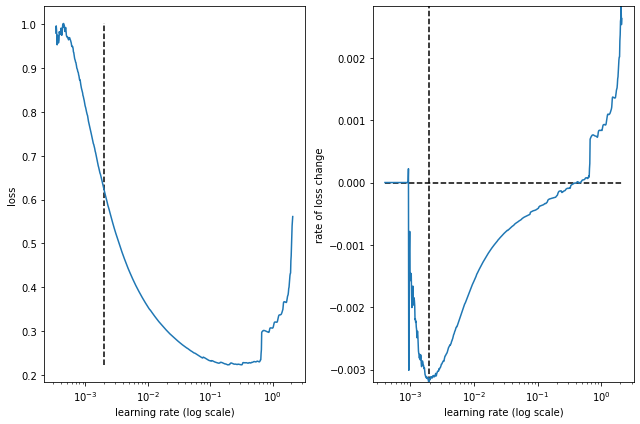

best lr: 0.0019465039 

Epoch 1/5
5881/5881 [==============================] - 7s 892us/step - loss: 0.9554 - mae: 0.4539 - mape: 144.7953


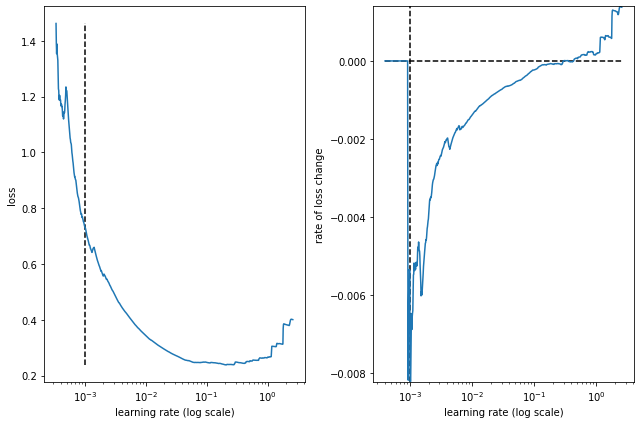

best lr: 0.0010202343 

Epoch 1/5
5881/5881 [==============================] - 7s 944us/step - loss: 0.9108 - mae: 0.4789 - mape: 151.9661


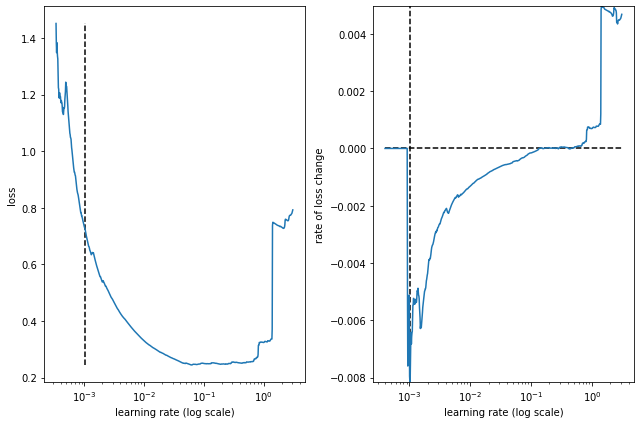

best lr: 0.0010202343 

Epoch 1/5
22225/22225 [==============================] - 22s 912us/step - loss: 0.5053 - mae: 0.3662 - mape: 406.3399


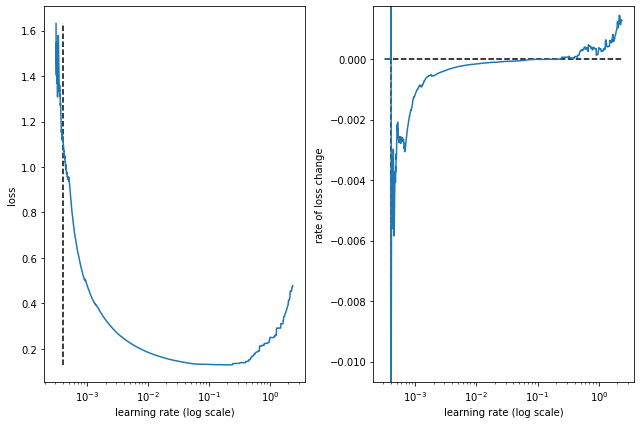

best lr: 0.0004085746 

Epoch 1/5
22227/22227 [==============================] - 24s 996us/step - loss: 0.5280 - mae: 0.3811 - mape: 183.2864


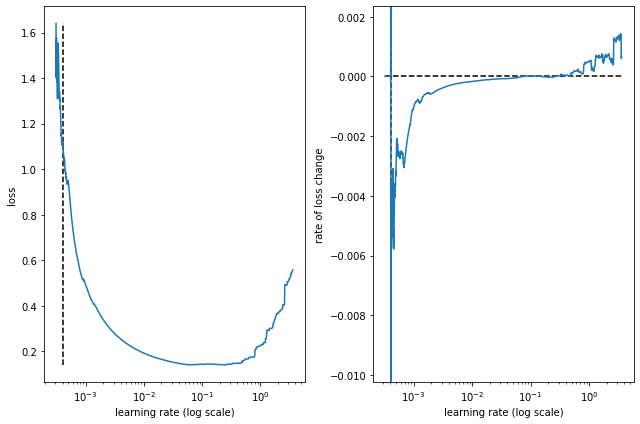

best lr: 0.0004085632 



In [36]:
def compile_fit_validate(model, train, valid, epochs = 5, verbose = 2):
    # Reduces variance in results but won't eliminate it :-(
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)

    # opt = Adam(lr = 0.0001)    
    opt = Adam(lrf[model.name].best_lr)

    model.compile(optimizer = opt, loss = 'mse', metrics = ['mae', 'mape']) 
       
    es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)
    lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, min_lr = 0.0001)
   
    h = model.fit(train, validation_data = valid,
                  epochs = epochs, verbose = verbose, callbacks = [es, lr])
    
    return h

    
def plot_history(h, name, epochs = 10):
    fig, axs = plt.subplots(1, 2, figsize = (9, 6), tight_layout = True)
    axs = axs.ravel()

    axs[0].plot(h.history['loss'])
    axs[0].plot(h.history['val_loss'])
    axs[0].set_title(name + ' loss')
    axs[0].set_xticklabels(range(1, epochs + 1))
    axs[0].set_xticks(range(0, epochs))
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'valid'], loc = 'upper right')

    axs[1].plot(h.history['mape'])
    axs[1].plot(h.history['val_mape'])
    axs[1].set_title(name + ' mape')
    axs[1].set_xticks(range(0, epochs))
    axs[1].set_xticklabels(range(1, epochs + 1))
    axs[1].set_title(name + ' mape')
    axs[1].set_ylabel('mape')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'valid'], loc = 'upper right')
    plt.show()

    return None

    
def print_min_loss(h, name):
    argmin_loss     = np.argmin(np.array(h.history['loss']))
    argmin_val_loss = np.argmin(np.array(h.history['val_loss']))
    min_loss        = h.history['loss'][argmin_loss]
    min_val_loss    = h.history['val_loss'][argmin_val_loss]
    mape            = h.history['mape'][argmin_loss]
    val_mape        = h.history['val_mape'][argmin_val_loss]
    mae             = h.history['mae'][argmin_loss]
    val_mae         = h.history['val_mae'][argmin_val_loss]
    
    txt = "{0:s} {1:s} min loss: {2:f}\tmae: {3:f}\tmape: {4:f}\tepoch: {5:d}"
    print(txt.format(name, "train", min_loss,     mae,     mape,     argmin_loss + 1))
    print(txt.format(name, "valid", min_val_loss, val_mae, val_mape, argmin_val_loss + 1))
    print()

    return None


def get_io_shapes(data):
    for batch in data.take(1):
        in_shape  = batch[0][0].shape
        out_shape = batch[1][0].shape
        
    return in_shape, out_shape


def build_vanilla_lstm_model(name, data, n_feature_maps = 8):
    in_shape, out_shape = get_io_shapes(data)
    out_steps = out_shape[0]

    lstm = Sequential(name = name)
    lstm.add(InputLayer(input_shape = in_shape))

    # Shape [batch, time, features] => [batch, n_feature_maps]
    lstm.add(LSTM(n_feature_maps, return_sequences = False))

    # Shape => [batch, out_steps]
    lstm.add(Dense(out_steps,
                   kernel_initializer = tf.initializers.zeros()))

    return lstm


def run_model(model, train, valid, epochs = 5):
    in_shape, out_shape = get_io_shapes(train)
    model_id = model.name + ' model - ' + str(in_shape[0]) + \
               ' lags ' + str(out_shape[0]) + ' steps-ahead -'
    
    model.summary()
    h = compile_fit_validate(model, train, valid, epochs)
    plot_history(h, model_id, epochs)
    print_min_loss(h, model_id)
    
    return h


models = {}
feat_maps = 16

models['lstm_24l_1s'] = build_vanilla_lstm_model('lstm_24l_1s', 
                                                 ds['train_24l_1s'], 
                                                 feat_maps)
models['lstm_24l_1s_t2v'] = build_vanilla_lstm_model('lstm_24l_1s_t2v', 
                                                     ds['train_24l_1s_t2v'], 
                                                     feat_maps)

models['lstm_24l_4s'] = build_vanilla_lstm_model('lstm_24l_4s', 
                                                 ds['train_24l_4s'], 
                                                 feat_maps)
models['lstm_24l_1s_2m'] = build_vanilla_lstm_model('lstm_24l_1s_2m', 
                                                    ds['train_24l_1s_2m'], 
                                                    feat_maps)
models['lstm_24l_4s_2m'] = build_vanilla_lstm_model('lstm_24l_4s_2m', 
                                                    ds['train_24l_4s_2m'], 
                                                    feat_maps)
model = models['lstm_24l_1s_t2v']
model.compile(loss = 'mse', metrics = ['mae', 'mape'])
lrf_lstm_24l_1s_t2v = LRFinder(model)
lrf_lstm_24l_1s_t2v.summarise_lr(ds['train_24l_1s_t2v'], 0.0003, 10, 32, 5, 100, 25)
lrf['lstm_24l_1s_t2v'] = lrf_lstm_24l_1s_t2v

model = models['lstm_24l_1s']
model.compile(loss = 'mse', metrics = ['mae', 'mape'])
lrf_lstm_24l_1s = LRFinder(model)
lrf_lstm_24l_1s.summarise_lr(ds['train_24l_1s'], 0.0003, 10, 32, 5, 100, 25)
lrf['lstm_24l_1s'] = lrf_lstm_24l_1s

model = models['lstm_24l_4s']
model.compile(loss = 'mse', metrics = ['mae', 'mape'])
lrf_lstm_24l_4s = LRFinder(model)
lrf_lstm_24l_4s.summarise_lr(ds['train_24l_4s'], 0.0003, 10, 32, 5, 100, 25)
lrf['lstm_24l_4s'] = lrf_lstm_24l_4s

model = models['lstm_24l_1s_2m']
model.compile(loss = 'mse', metrics = ['mae', 'mape'])
lrf_lstm_24l_1s_2m = LRFinder(model)
lrf_lstm_24l_1s_2m.summarise_lr(ds['train_24l_1s_2m'], 0.0003, 10, 32, 5, 100, 25)
lrf['lstm_24l_1s_2m'] = lrf_lstm_24l_1s_2m

model = models['lstm_24l_4s_2m']
model.compile(loss = 'mse', metrics = ['mae', 'mape'])
lrf_lstm_24l_4s_2m = LRFinder(model)
lrf_lstm_24l_4s_2m.summarise_lr(ds['train_24l_4s_2m'], 0.0003, 10, 32, 5, 100, 25)
lrf['lstm_24l_4s_2m'] = lrf_lstm_24l_4s_2m

The learning rate finder has a surprisingly low run time; possibly because the loss quickly becomes infinite at high learning rates.

Unaugmented single step ahead (both univariate temperature and multivariate) and 4 steps ahead data sets have similar optimal learning rates.  Best learning rates for the single step ahead and 4 steps ahead data sets with mixup are very similar.  The learning rate finder is ran for two Time2Vec models below.


---

Finally, run vanilla LSTM with optimised learning rates:
 * single step-ahead
   * without mixup
   * with mixup
 * **TODO** approx. run time
 * ...

Model: "lstm_24l_1s"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 16)                1728      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 1,745
Trainable params: 1,745
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
5881/5881 - 42s - loss: 0.0472 - mae: 0.1193 - mape: 46.2881 - val_loss: 0.0125 - val_mae: 0.0664 - val_mape: 27.5440
Epoch 2/5
5881/5881 - 38s - loss: 0.0104 - mae: 0.0632 - mape: 30.1424 - val_loss: 0.0118 - val_mae: 0.0647 - val_mape: 27.3690
Epoch 3/5
5881/5881 - 38s - loss: 0.0099 - mae: 0.0616 - mape: 29.1930 - val_loss: 0.0117 - val_mae: 0.0647 - val_mape: 26.7129
Epoch 4/5
5881/5881 - 39s - loss: 0.0097 - mae: 0.0611 - mape: 28.8894 - val_loss: 0.0113 - val_mae: 0.0634 - val_mape: 26.4181
Epo

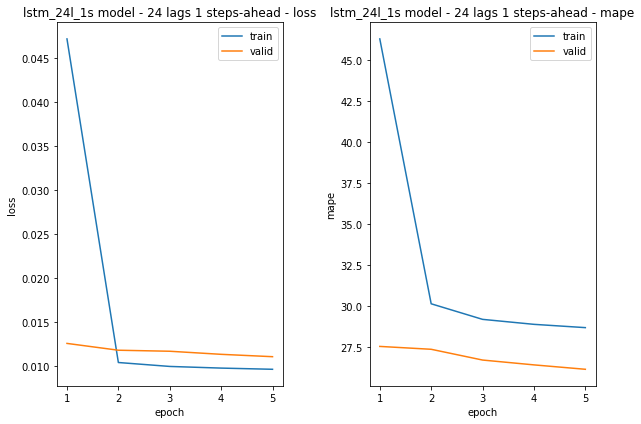

lstm_24l_1s model - 24 lags 1 steps-ahead - train min loss: 0.009598	mae: 0.060649	mape: 28.688938	epoch: 5
lstm_24l_1s model - 24 lags 1 steps-ahead - valid min loss: 0.011031	mae: 0.062525	mape: 26.149940	epoch: 5

Model: "lstm_24l_1s_2m"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 16)                1728      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total params: 1,745
Trainable params: 1,745
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
22237/22237 - 148s - loss: 0.0269 - mae: 0.0792 - mape: 62.8792 - val_loss: 0.0047 - val_mae: 0.0441 - val_mape: 20.8564
Epoch 2/5
22237/22237 - 143s - loss: 0.0031 - mae: 0.0339 - mape: 25.9219 - val_loss: 0.0039 - val_mae: 0.0372 - val_mape: 18.6829
Epoch 3/5
22237/22237 - 141s - lo

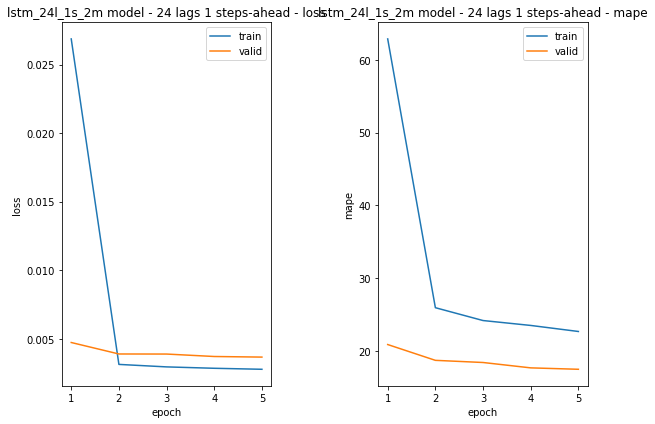

lstm_24l_1s_2m model - 24 lags 1 steps-ahead - train min loss: 0.002776	mae: 0.030820	mape: 22.651180	epoch: 5
lstm_24l_1s_2m model - 24 lags 1 steps-ahead - valid min loss: 0.003665	mae: 0.035663	mape: 17.453712	epoch: 5



In [17]:
h = {}  # history
h['lstm_24l_1s'] = run_model(models['lstm_24l_1s'], ds['train_24l_1s'], ds['valid_24l_1s'], epochs = 5)

h['lstm_24l_1s_2m'] = run_model(models['lstm_24l_1s_2m'], ds['train_24l_1s_2m'], ds['valid_24l_1s_2m'], epochs = 5)

...

---

Secondly, vanilla LSTM with optimised learning rates - 4 steps ahead:
 * without mixup
 * with mixup
 * **TODO** approx. run time
 * ...

...

Model: "lstm_24l_4s"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 16)                1728      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 68        
Total params: 1,796
Trainable params: 1,796
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
5881/5881 - 56s - loss: 0.0189 - mae: 0.0902 - mape: 41.9209 - val_loss: 0.0203 - val_mae: 0.0886 - val_mape: 37.6592
Epoch 2/5
5881/5881 - 56s - loss: 0.0188 - mae: 0.0898 - mape: 41.7755 - val_loss: 0.0204 - val_mae: 0.0892 - val_mape: 37.8212
Epoch 3/5
5881/5881 - 56s - loss: 0.0187 - mae: 0.0896 - mape: 41.6494 - val_loss: 0.0204 - val_mae: 0.0897 - val_mape: 38.0342
Epoch 4/5
5881/5881 - 56s - loss: 0.0186 - mae: 0.0894 - mape: 41.5523 - val_loss: 0.0203 - val_mae: 0.0894 - val_mape: 37.3785
Epo

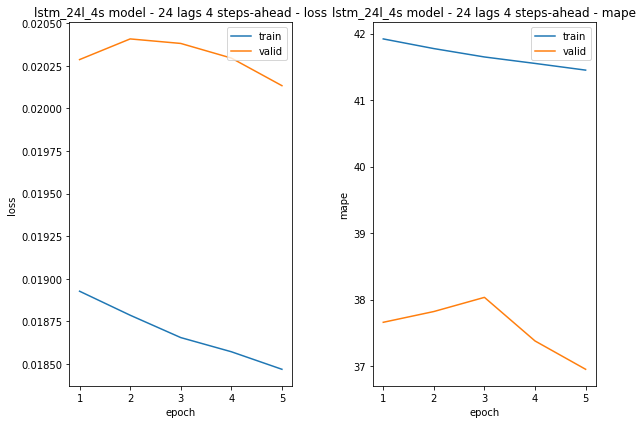

lstm_24l_4s model - 24 lags 4 steps-ahead - train min loss: 0.018469	mae: 0.089188	mape: 41.451580	epoch: 5
lstm_24l_4s model - 24 lags 4 steps-ahead - valid min loss: 0.020134	mae: 0.088685	mape: 36.952713	epoch: 5

Model: "lstm_24l_4s_m2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 16)                1728      
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 68        
Total params: 1,796
Trainable params: 1,796
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
22243/22243 - 209s - loss: 0.0115 - mae: 0.0510 - mape: 29.2402 - val_loss: 0.0054 - val_mae: 0.0434 - val_mape: 29.7558
Epoch 2/5
22243/22243 - 220s - loss: 0.0045 - mae: 0.0400 - mape: 25.6781 - val_loss: 0.0051 - val_mae: 0.0416 - val_mape: 28.3262
Epoch 3/5
22243/22243 - 224s - lo

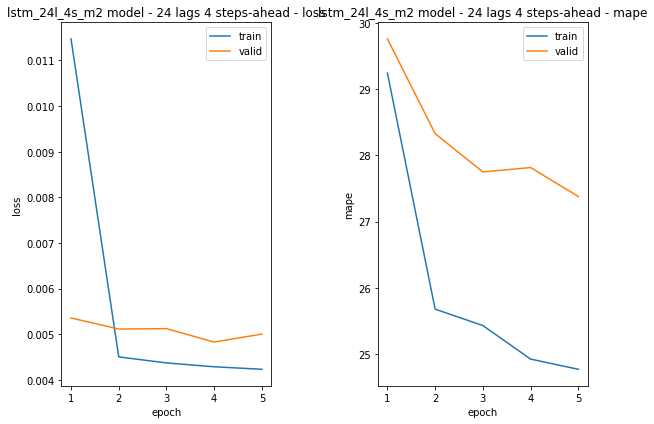

lstm_24l_4s_m2 model - 24 lags 4 steps-ahead - train min loss: 0.004233	mae: 0.038624	mape: 24.771168	epoch: 5
lstm_24l_4s_m2 model - 24 lags 4 steps-ahead - valid min loss: 0.004829	mae: 0.039328	mape: 27.814888	epoch: 4



In [ ]:
h['lstm_24l_4s'] = run_model(models['lstm_24l_4s'], ds['train_24l_4s'], ds['valid_24l_4s'], epochs = 5)

h['lstm_24l_4s_2m'] = run_model(models['lstm_24l_4s_2m'], ds['train_24l_4s_2m'], ds['valid_24l_4s_2m'], epochs = 5)

...

---

### Time2Vec


The [Time2Vec](https://arxiv.org/pdf/1907.05321.pdf) method learns a vector representation of both periodic and non-periodic patterns using sine and linear activations.  Time can be measured on different scales, eg. years, days, hours.  Time2Vec is invariant to time rescaling and is  model-agnostic, meaning it can be used with many existing architectures.  

The learnable parameters are the frequencies and phase shifts of the sine function.  There are similarities with the hardcoded daily and yearly `sin` time components used above; which use 2 frequencies, no phase shifts and no non-periodic components.  See the [Time2Vec paper](https://arxiv.org/pdf/1907.05321.pdf) for a detailed explanation and negative reviews on [OpenReview.net](https://openreview.net/forum?id=rklklCVYvB).

Fourier terms, which use equally spaced frequencies, are one obvious alternative temporal representation.

The Time2Vec representation is implemented using a keras layer based on code from [Marco Cerliani](https://github.com/cerlymarco/MEDIUM_NoteBook/blob/master/Time2Vec/Time2Vec.ipynb), which has been adapted for use with my utilility functions.

The `NN` and `T2V_NN` function parameters used below were chosen to produce similarly sized models for a fair comparison (4,124 for `NN` and 4,154 for `T2V_NN`).  Only univariate temperature data is considered.


Epoch 1/5
5881/5881 [==============================] - 7s 807us/step - loss: 0.5219 - mae: 0.3340 - mape: 129.4432


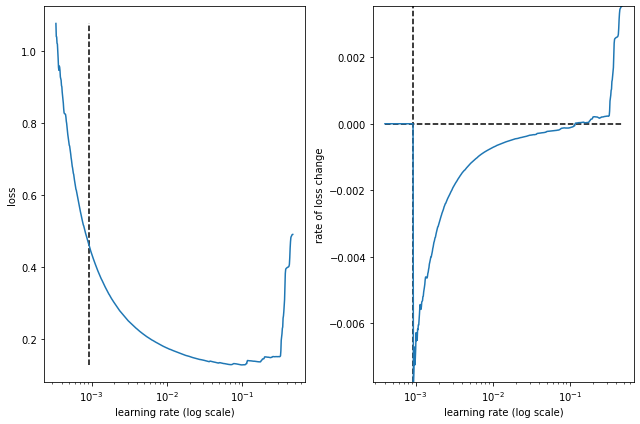

best lr: 0.0009318022 

Epoch 1/5
5881/5881 [==============================] - 8s 1ms/step - loss: 0.5889 - mae: 0.4316 - mape: 155.6919


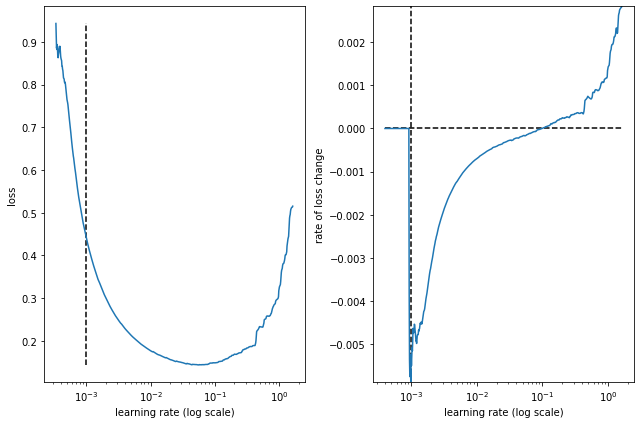

best lr: 0.0009861293 

Model: "lstm_24l_1s_gen"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 24, 1)]           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 31)                4092      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 32        
Total params: 4,124
Trainable params: 4,124
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
5881/5881 - 32s - loss: 0.0187 - mae: 0.0778 - mape: 36.2596 - val_loss: 0.0126 - val_mae: 0.0645 - val_mape: 27.6023
Epoch 2/20
5881/5881 - 30s - loss: 0.0112 - mae: 0.0645 - mape: 31.1872 - val_loss: 0.0123 - val_mae: 0.0639 - val_mape: 27.5177
Epoch 3/20
5881/5881 - 30s - loss: 0.0109 - mae: 0.0636 - mape: 30.8033 - val_loss: 0.0115 - val_

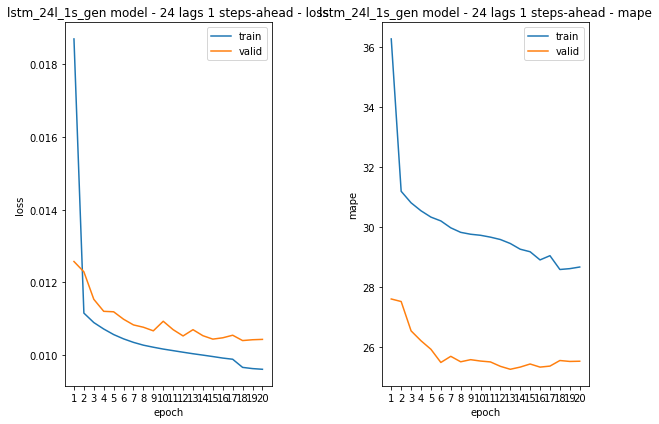

lstm_24l_1s_gen model - 24 lags 1 steps-ahead - train min loss: 0.009613	mae: 0.060151	mape: 28.666370	epoch: 20
lstm_24l_1s_gen model - 24 lags 1 steps-ahead - valid min loss: 0.010403	mae: 0.058044	mape: 25.554062	epoch: 18

Model: "lstm_24l_1s_t2v"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 24, 1)]           0         
_________________________________________________________________
t2v_12 (T2V)                 (None, 24, 34)            873       
_________________________________________________________________
lstm_23 (LSTM)               (None, 16)                3264      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 17        
Total params: 4,154
Trainable params: 4,154
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
5881/5881

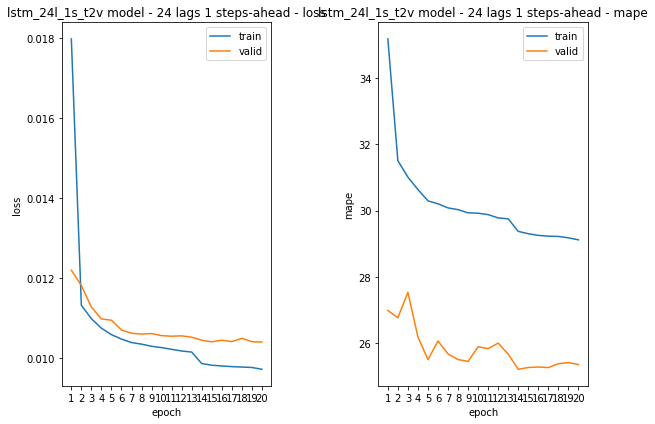

lstm_24l_1s_t2v model - 24 lags 1 steps-ahead - train min loss: 0.009726	mae: 0.060312	mape: 29.117634	epoch: 20
lstm_24l_1s_t2v model - 24 lags 1 steps-ahead - valid min loss: 0.010406	mae: 0.058048	mape: 25.360973	epoch: 20



In [52]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

class T2V(Layer):
    
    def __init__(self, output_dim = None, **kwargs):
        '''
        Implements a Time2Vec layer based on:
          [1] Time2Vec: Learning a Vector Representation of Time,
              Kazemi et al., 2019.
        '''
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # W and P correspond to omega_i and phi_i for i != 0 from [1]
        # omega_i and phi_i represent the frequency and phase-shift
        self.W = self.add_weight(name = 'W',
                                shape = (input_shape[-1], self.output_dim),
                                initializer = 'uniform',
                                trainable   = True)

        self.P = self.add_weight(name = 'P',
                                shape = (input_shape[1], self.output_dim),
                                initializer = 'uniform',
                                trainable   = True)

        # w and p correspond to omega_0 and phi_0 for i = 0 from [1]
        self.w = self.add_weight(name = 'w',
                                shape = (input_shape[1], 1),
                                initializer = 'uniform',
                                trainable   = True)

        self.p = self.add_weight(name = 'p',
                                shape = (input_shape[1], 1),
                                initializer = 'uniform',
                                trainable   = True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        '''
        Time2Vec layer forward method.  The input signal (tensor) contains
        a sequence with dimension -> features_dim.
            Args:
                x (tensor):       Input signal (tensor)
                                  (batch_size, sequence_length, features_dim)
            Returns:
                A tensor that contains the concatenation of a predictive and a
                progressive signal, respectively.
            Notes:
                For instance, if the time2vec layer is being used in timeseries
                prediction the sequence length is the length of the timeseries
                chunk and the features dimension is 1 if the prediction horizon
                is one.

        :return: A Tensor with shape (batch_size, feature_size, length of time vector representation + 1)
        '''
        original  = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)


def T2V_NN(seq_len, n_feature_maps, t2v_size = 33):
        
    inp = Input(shape = (seq_len, 1))

    x = T2V(t2v_size)(inp)
    x = LSTM(n_feature_maps)(x)
    x = Dense(1)(x)
    
    m = Model(inp, x, name = 'lstm_24l_1s_t2v')
    
    return m


def NN(seq_len, n_feature_maps):
        
    inp = Input(shape = (seq_len, 1))

    x = LSTM(n_feature_maps)(inp)
    x = Dense(1)(x)
    
    m = Model(inp, x, name = 'lstm_24l_1s_gen')
    
    return m


SEQ_LEN  = 24
modelgen =     NN(SEQ_LEN, 31)
modelt2v = T2V_NN(SEQ_LEN, 16)

modelgen.compile(loss = 'mse', metrics = ['mae', 'mape'])
lrf_lstm_24l_1s_gen = LRFinder(modelgen)
lrf_lstm_24l_1s_gen.summarise_lr(ds['train_24l_1s_t2v'], 0.0003, 10, 32, 5, 100, 25)
lrf['lstm_24l_1s_gen'] = lrf_lstm_24l_1s_gen

modelt2v.compile(loss = 'mse', metrics = ['mae', 'mape'])
lrf_lstm_24l_1s_t2v = LRFinder(modelt2v)
lrf_lstm_24l_1s_t2v.summarise_lr(ds['train_24l_1s_t2v'], 0.0003, 10, 32, 5, 100, 25)
lrf['lstm_24l_1s_t2v'] = lrf_lstm_24l_1s_t2v


h = {}
h['lstm_gen_24l_1s'] = run_model(modelgen, ds['train_24l_1s_t2v'], ds['valid_24l_1s_t2v'], epochs = 20)
h['lstm_t2v_24l_1s'] = run_model(modelt2v, ds['train_24l_1s_t2v'], ds['valid_24l_1s_t2v'], epochs = 20)

Very similar results with and without time2vec layer, so I'm not going to expand time2vec testing to the full multi-variate data sets or longer horizons.


---

...

...

...

---


## Conclusion

Fortunately, ...

On an unrealted matter, ...

Future work:
 * ...

---

## Metadata

Python and Jupyter versions plus modules imported and their version strings. 
This is the poor man's python equivalent of R's sessionInfo().

Code for imported modules and versions adapted from this stackoverflow answer. 
There are simpler alternatives, such as watermark, but they all require installation.

In [ ]:
import sys
import IPython

print("Python version:")
print(sys.executable)
print(sys.version)
print("\nIPython version:")
print(IPython.__version__)

Python version:
/usr/bin/python3
3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]

IPython version:
5.5.0


In [ ]:
import pkg_resources
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names.  Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name.  You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL":       "Pillow",
            "sklearn":   "scikit-learn",
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

reqs = pd.DataFrame(requirements, columns = ['name', 'version'])
print("Imported modules:")
reqs.style.hide_index()

Imported modules:


name,version
statsmodels,0.10.2
pandas,1.1.5
numpy,1.19.5
matplotlib,3.2.2


In [ ]:
!date

Thu Apr 22 20:52:55 UTC 2021


---


## Archival

Archive code, markdown, history and formatted notebooks.

Assumes all pdf, html, latex etc dependencies are installed.

**WARNING** Will overwrite existing files.

Notebook name is hardcoded below because the alternative is ghastly globs of unreliable javascript or external ipython libraries I'd prefer to avoid installing :-(

In [ ]:
from time import sleep

notebook = "cammet_baselines_2021.ipynb"
# !jupyter nbconvert --to script {notebook}
# !jupyter nbconvert --execute --to html {notebook}
# !jupyter nbconvert --execute --to pdf {notebook}
# !jupyter nbconvert --to pdf {notebook}

%rm history.txt
%history -f history.txt

!jupyter nbconvert --to python {notebook}
sleep(5)
!jupyter nbconvert --to markdown {notebook}
sleep(5)
!jupyter nbconvert --to html {notebook}